In [2]:
from pylab import *
import openfst
from openfst import StdVectorFst as FST
from openfst import LogVectorFst as LFST
from fstutils import *
figsize(12,6)

# Simple Edit Distance

It's easy in principle to compute edit distance with finite state transducers.
We construct a transducer that takes takes each symbol in the alphabet to itself with cost 0,
and takes each symbol to a different symbol, or to/from epsilon with cost 1.
This transducer is called a *flower transducer* because of its appearance.

We then compose an FST corresponding to the first string with this transducer,
compose the result with an FST corresponding to the second string, and compute
the cost of the shortest path.


In [3]:
def make_flower(chars):
    epsilon = 0
    fst = FST()
    s = fst.AddState()
    fst.SetStart(s)
    fst.SetFinal(s,0.0)
    for c in chars:
        c = ord(c)
        fst.AddArc(s,c,c,0.0,s)
        fst.AddArc(s,c,epsilon,1.0,s)
        fst.AddArc(s,epsilon,c,1.0,s)
        for c2 in chars:
            c2 = ord(c2)
            fst.AddArc(s,c,c2,1.0,s)
    return fst

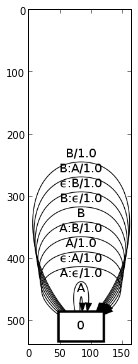

In [4]:
flower = make_flower("AB")
show_fst(flower)

In [5]:
fst1 = FST()
fst1.AddString("AABBAAA")
fst2 = FST()
fst2.AddString("AABBABAB")

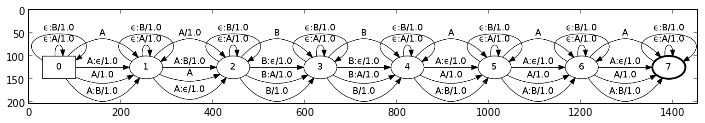

In [6]:
temp1 = FST()
openfst.ArcSortOutput(fst1)
openfst.ArcSortInput(flower)
openfst.Compose(fst1,flower,temp1)
show_fst(temp1)

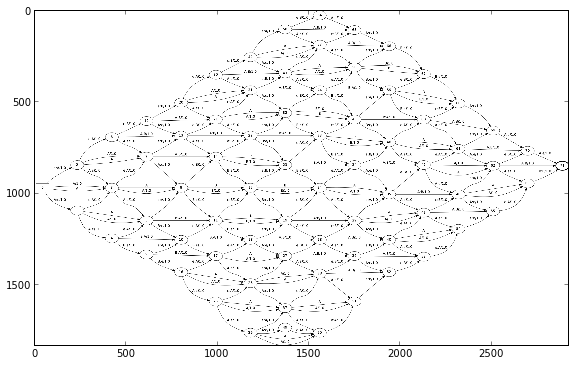

In [7]:
temp2 = FST()
openfst.ArcSortOutput(temp1)
openfst.ArcSortInput(fst2)
openfst.Compose(temp1,fst2,temp2)
show_fst(temp2)

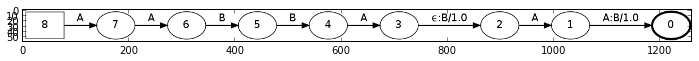

In [8]:
result = FST()
openfst.ShortestPath(temp2,result,1)
show_fst(result)

In [9]:
print fstsize(temp1),fstsize(temp2)

(8, 44) (72, 211)


# Factoring the Edit Distance Transducer

The problem with the previous transducer is that it gets very large very quickly when
composed with the original string. In fact, the size ends up being quadratic.

We can fix this by introducing some additional symbols. 
(Here, we're just using ASCII symbols to represent insertion, deletion, and substitution, but we could
be using something fancier.)

In [10]:
epsilon = 0
insertion = ord("#")
deletion = ord("_")
substitution = ord("~")

def make_left(chars):
    fst = FST()
    s = fst.AddState()
    fst.SetStart(s)
    fst.SetFinal(s,0.0)
    fst.AddArc(s,epsilon,insertion,0.5,s)
    for c in chars:
        c = ord(c)
        fst.AddArc(s,c,c,0.0,s)
        fst.AddArc(s,c,substitution,0.5,s)
        fst.AddArc(s,c,deletion,0.5,s)
    return fst

def make_right(chars):
    fst = FST()
    s = fst.AddState()
    fst.SetStart(s)
    fst.SetFinal(s,0.0)
    fst.AddArc(s,deletion,epsilon,0.5,s)
    for c in chars:
        c = ord(c)
        fst.AddArc(s,c,c,0.0,s)
        fst.AddArc(s,substitution,c,0.5,s)
        fst.AddArc(s,insertion,c,0.5,s)
    return fst

In [11]:
temp1 = FST()
temp2 = FST()
openfst.Compose(fst1,make_left("AB"),temp1)
openfst.Compose(make_right("AB"),fst2,temp2)
print fstsize(temp1),fstsize(temp2)

(8, 29) (9, 33)


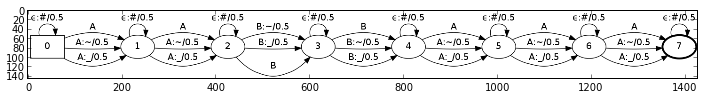

In [12]:
show_fst(temp1)

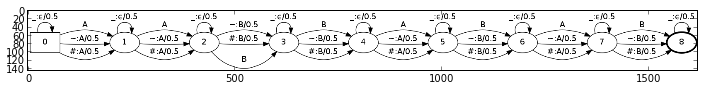

In [13]:
show_fst(temp2)

(9, 8)


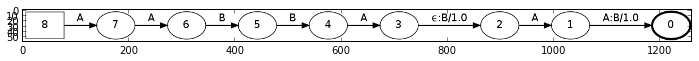

In [14]:
temp3 = FST()
openfst.ArcSortOutput(temp1)
openfst.ArcSortInput(temp2)
openfst.Compose(temp1,temp2,temp3)
result = FST()
openfst.ShortestPath(temp3,result,1)
print fstsize(result)
show_fst(result)

This becomes particularly important when using larger alphabets. Here is an illustration.

In [15]:
ascii = "".join([chr(c) for c in range(32,127) if c not in [ord("~"),ord("_"),ord("#")]])

In [16]:
ascii_left = make_left(ascii)
ascii_right = make_right(ascii)

In [17]:
def edit_distance(s1,s2):
    fst1 = FST()
    fst1.AddString(s1)
    fst2 = FST()
    fst2.AddString(s2)
    temp1 = FST()
    temp2 = FST()
    openfst.Compose(fst1,ascii_left,temp1)
    openfst.Compose(ascii_right,fst2,temp2)
    print fstsize(temp1),fstsize(temp2)
    temp3 = FST()
    openfst.ArcSortOutput(temp1)
    openfst.ArcSortInput(temp2)
    openfst.Compose(temp1,temp2,temp3)
    print fstsize(temp3)
    result = FST()
    openfst.ShortestPath(temp3,result,1)
    return result

(10, 37) (11, 41)
(110, 296)


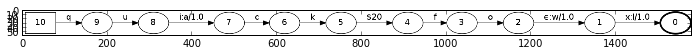

In [18]:
show_fst(edit_distance("quick fox","quack fowl"))

# Limited Contiguous Insertions / Deletions

A second way in which we can make edit distance computations more efficient
is to limit the number of consecutive deletions/insertions that can occur.

(Think about what constraint this corresponds to for a "manual" computation of the edit distance.)

In [19]:
epsilon = 0
def make_edit1(chars):
    fst = FST()
    s = fst.AddState()
    s2 = fst.AddState()
    fst.SetStart(s)
    fst.SetFinal(s,0.0)
    fst.SetFinal(s2,0.0)
    for c in chars:
        c = ord(c)
        fst.AddArc(s,c,c,0.0,s)
        fst.AddArc(s,c,epsilon,1.0,s2)
        fst.AddArc(s,epsilon,c,1.0,s2)
        fst.AddArc(s2,c,c,0.0,s)
        for c2 in chars:
            c2 = ord(c2)
            fst.AddArc(s,c,c2,1.0,s)
            fst.AddArc(s2,c,c2,1.0,s)
    return fst

(56, 115)


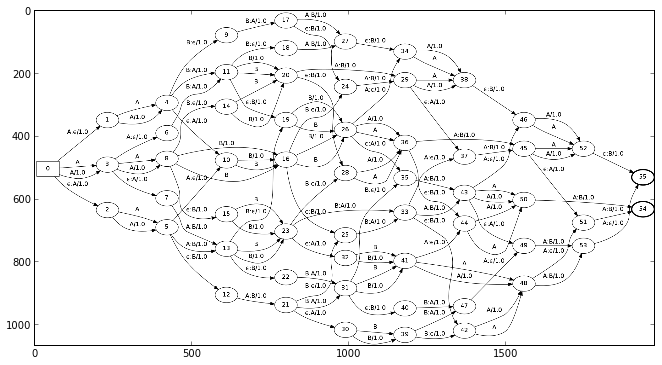

In [20]:
temp1 = FST()
openfst.ArcSortOutput(fst1)
efst = make_edit1("AB")
openfst.ArcSortInput(efst)
openfst.Compose(fst1,efst,temp1)
show_fst(temp1)
temp2 = FST()
openfst.ArcSortOutput(temp1)
openfst.ArcSortInput(fst2)
openfst.Compose(temp1,fst2,temp2)
show_fst(temp2)
print fstsize(temp2)

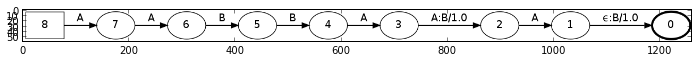

In [21]:
result = FST()
openfst.ShortestPath(temp2,result,1)
show_fst(result)

(72, 211)


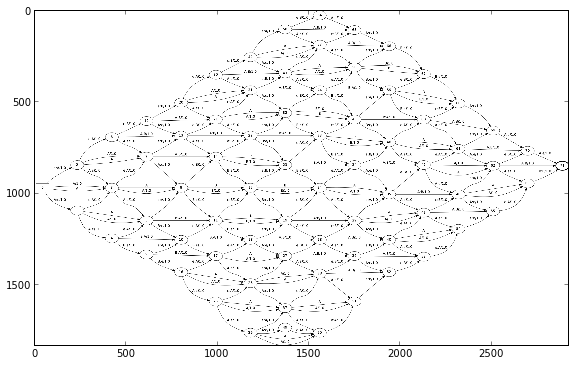

In [22]:
temp1 = FST()
openfst.ArcSortOutput(fst1)
efst = make_flower("AB")
openfst.ArcSortInput(efst)
openfst.Compose(fst1,efst,temp1)
show_fst(temp1)
temp2 = FST()
openfst.ArcSortOutput(temp1)
openfst.ArcSortInput(fst2)
openfst.Compose(temp1,fst2,temp2)
show_fst(temp2)
print fstsize(temp2)

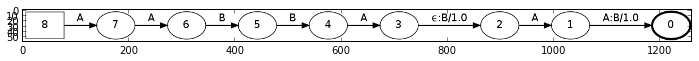

In [23]:
result = FST()
openfst.ShortestPath(temp2,result,1)
show_fst(result)

# Oracle Edit Distance

The regular edit distance is limited to computing the best match between two strings.
However, with finite state transducers, we can compute the best match between two
sets of strings.

In fact, the strings can even have weights or costs associated with them.

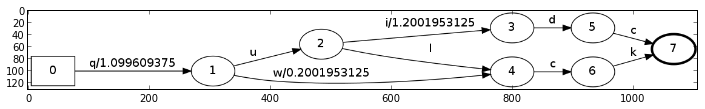

In [34]:
# recognition output
fst1 = FST()
fst1.AddString("qulck",1.1)
fst1.AddString("qwck",1.3)
fst1.AddString("quidc",2.3)
fst1 = minimize(fst1)
show_fst(fst1)

Let's actually use an English dictionary (albeit a small one) to find the closest string in this set
of hypotheses to some dictionary word.

Often, we'd simply precompute such a minimized representation of the dictionary and then use it
for further recognition.

In [35]:
# English dictionary
fst2 = FST()
with open("basic-english.txt") as stream:
    for line in stream.readlines():
        line = line.strip()
        fst2.AddString(line)
print fstsize(fst2)
fst2 = minimize(fst2)
print fstsize(fst2)

(4459, 4458)
(746, 1541)


In [36]:
temp2 = FST()
openfst.ArcSortOutput(ascii_right)
openfst.ArcSortInput(fst2)
openfst.Compose(ascii_right,fst2,temp2)
print fstsize(temp2)

(746, 5369)


Note that might actually try to "minimize" this dictionary transducer.
However, this doesn't work because this is a "non-functional FST".
In order to minimize this transducer, one needs to encode the labels,
determinize, then decode, and finally minimize.

In [37]:
# fst2 = minimize(fst2)

Now let's compose the set of hypotheses with the dictionary.

(8, 35) (746, 5369)
(5968, 33447)


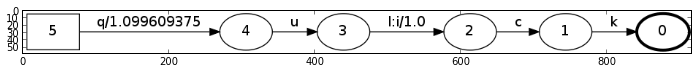

In [38]:
temp1 = FST()
openfst.Compose(fst1,ascii_left,temp1)
print fstsize(temp1),fstsize(temp2)
temp3 = FST()
openfst.ArcSortOutput(temp1)
openfst.ArcSortInput(temp2)
openfst.Compose(temp1,temp2,temp3)
print fstsize(temp3)
result = FST()
openfst.ShortestPath(temp3,result,1)
show_fst(result)